## はじめ09_6027と同じ

In [64]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [65]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

In [66]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

In [67]:
# Drafted を目的変数として切り離し
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

# School, Player_Type, Position_Type は使用しない場合は最初からdrop
X = X.drop(columns=["School", "Player_Type", "Position_Type"])
test = test.drop(columns=["School", "Player_Type", "Position_Type"])

# Position は Target Encoding + Group Encoding にのみ使用
# Label Encodingは不要


In [68]:
# PositionをTarget Encoding（全体平均ベース、これは許容範囲）
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# Position_groupを作成（これは合法・安全）
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

# fold-safeな target encoding を実施
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0  # 初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)

# testデータには全体平均から算出（合法）
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

# 不要な文字列列は削除（エラー防止）
X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

C:\Users\81807\AppData\Local\Temp\ipykernel_9832\3887577351.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 0

In [69]:
from sklearn.preprocessing import MinMaxScaler

# kg → lbs
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

# Speed Score
X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)

# Burst Score
X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]

# Agility Score
X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

# ASI（Athletic Score Index）
X["ASI"] = (
    0.5 * X["SpeedScore"] +
    0.3 * X["BurstScore"] +
    0.2 * X["AgilityScore"]
)
test["ASI"] = (
    0.5 * test["SpeedScore"] +
    0.3 * test["BurstScore"] +
    0.2 * test["AgilityScore"]
)

# RSA スケーリング特徴量作成
rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]

for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])


In [70]:
# 学習に使いたい全特徴量を明示的にリストアップ
all_features = [
    'Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
    'Broad_Jump', 'Agility_3cone', 'Shuttle',
    'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing',
    'ASI',  # ✅ 使用
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'  # ✅ 使用
]

# 重複削除
all_features = list(dict.fromkeys(all_features))

print(all_features)

['Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle', 'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing', 'ASI', 'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone']


In [71]:
all_features = [
    'Year', 'Height', 'Weight', 'Broad_Jump',
    'Position_encoded', 'Position_group_encoded',
    'Age_filled', 'Age_missing',
    'ASI',  # RSAに基づく重要指標
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'
]


In [72]:
X["BMI"] = X["Weight"] / (X["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

all_features += ["BMI"]
all_features = list(dict.fromkeys(all_features))

# all_features から Weight, Height を削除
all_features = [col for col in all_features if col not in ["Weight", "Height"]]

all_features = [col for col in all_features if col != "Age_missing"]


all_features = [f for f in all_features if f != "BMI"]

if "Weight" not in all_features:
    all_features.append("Weight")
if "Height" not in all_features:
    all_features.append("Height")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

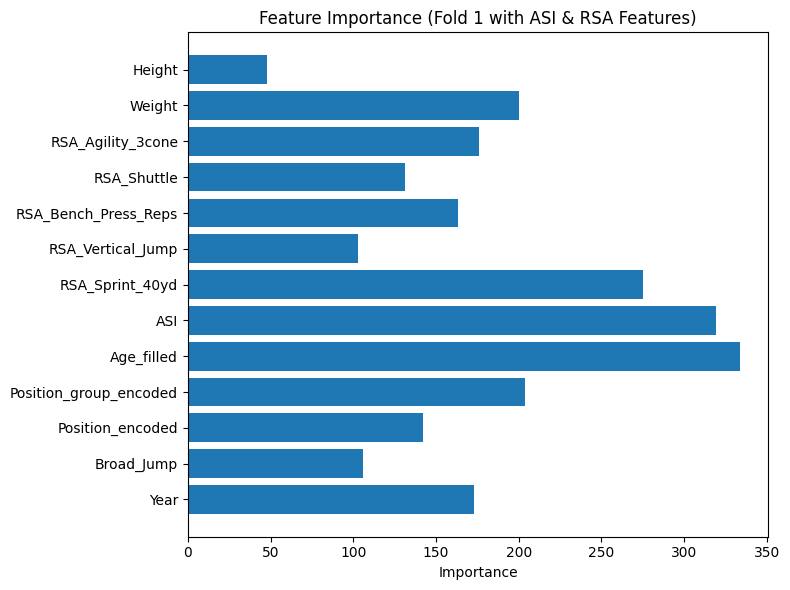

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [73]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

X_feat = X[all_features]
y_feat = y

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_feat)):
    X_train, X_valid = X_feat.iloc[train_idx], X_feat.iloc[valid_idx]
    y_train, y_valid = y_feat.iloc[train_idx], y_feat.iloc[valid_idx]
    
    model = LGBMClassifier(
        max_depth=4,
        num_leaves=10,
        min_child_samples=50,
        reg_alpha=5.0,
        reg_lambda=5.0,
        learning_rate=0.03,
        n_estimators=700,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_feat.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [74]:
# 🚩 School 列を復元する（削除済の場合）
if "School" not in X.columns:
    df_raw = pd.read_csv("../data/train.csv")
    X["School"] = df_raw["School"]

if "School" not in test.columns:
    test_raw = pd.read_csv("../data/test.csv")
    test["School"] = test_raw["School"]

print("✅ School 列を復元完了")


✅ School 列を復元完了


In [75]:
# =====================================================
# 🎯 School 特徴量エンジニアリング（合法ドメイン知識活用）
# =====================================================

import pandas as pd
from sklearn.model_selection import KFold

# 1️⃣ Drafted 数・率を school ごとに集計
school_stats = X.copy()
school_stats["Drafted"] = y
school_agg = school_stats.groupby("School")["Drafted"].agg(["sum", "count"])
school_agg["Drafted_Rate"] = school_agg["sum"] / school_agg["count"]

# School_Drafted_Count (スカウト注目度の proxy)
school_drafted_count = school_agg["sum"]

# School_Drafted_Rate
school_drafted_rate = school_agg["Drafted_Rate"]

# 2️⃣ 常連校フラグ作成（Drafted 数上位 20 校を常連校とする例）
top_n = 20
top_schools = school_drafted_count.sort_values(ascending=False).head(top_n).index.tolist()

X["School_Top"] = X["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

# 3️⃣ School_Drafted_Count をマッピング
X["School_Drafted_Count"] = X["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School_Drafted_Count"].fillna(0)  # 未知校は 0 扱い

# 4️⃣ fold-safe Target Encoding (School_Drafted_Rate)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["School_Drafted_Rate_TE"] = 0.0  # floatで初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    rate_map = X_train.assign(Drafted=y_train).groupby("School")["Drafted"].mean()
    X.loc[val_idx, "School_Drafted_Rate_TE"] = X.loc[val_idx, "School"].map(rate_map)

# test には全体の rate_map で付与
final_rate_map = X.assign(Drafted=y).groupby("School")["Drafted"].mean()
test["School_Drafted_Rate_TE"] = test["School"].map(final_rate_map)
test["School_Drafted_Rate_TE"] = test["School_Drafted_Rate_TE"].fillna(y.mean())  # 未知校は平均で補完

# 5️⃣ 不要な元の School 列は削除
X = X.drop(columns=["School"])
test = test.drop(columns=["School"])

# 6️⃣ 追加特徴量リストに加える場合
new_school_features = ["School_Top", "School_Drafted_Count", "School_Drafted_Rate_TE"]
for col in new_school_features:
    if col not in all_features:
        all_features.append(col)

print(f"✅ School 特徴量エンジニアリング完了: {new_school_features}")


✅ School 特徴量エンジニアリング完了: ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']


In [76]:
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))  # 重複排除


In [77]:
# 特徴量追加
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))

# 学習・スコア確認へ進む


In [78]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import numpy as np

# ✅ 08モデルパラメータ固定
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# ここまで09_6027と同じ

## 13でやること

✅ Test_Participation_Count を作成（EDA段階で分布可視化）

✅ Age_missing を復活

✅ Premium_Position を追加

### ✅ Test_Participation_Count を作成（EDA段階で分布可視化）

In [79]:
# Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Broad_Jump, Agility_3cone, Shuttle の欠損がない列をカウント
test_cols = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Broad_Jump", "Agility_3cone", "Shuttle"]
X["Test_Participation_Count"] = X[test_cols].notna().sum(axis=1)
test["Test_Participation_Count"] = test[test_cols].notna().sum(axis=1)


### ✅ Age_missing を復活

In [80]:
# Age_filled = -1 であるものを欠損フラグ1、それ以外0
X["Age_missing"] = (X["Age_filled"] == -1).astype(int)
test["Age_missing"] = (test["Age_filled"] == -1).astype(int)


### ✅ Premium_Position を追加

In [81]:
premium_positions = ["QB", "WR", "OT", "DE", "CB"]

if "Position" in X.columns:
    X["Premium_Position"] = X["Position"].isin(premium_positions).astype(int)
else:
    X["Premium_Position"] = 0  # 既に削除済の場合は0埋め

if "Position" in test.columns:
    test["Premium_Position"] = test["Position"].isin(premium_positions).astype(int)
else:
    test["Premium_Position"] = 0



In [82]:
for col in ["Test_Participation_Count", "Age_missing", "Premium_Position"]:
    if col not in all_features:
        all_features.append(col)


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.861641	valid_0's binary_logloss: 0.399889
✅ Fold 1 - Train AUC: 0.9256, Validation AUC: 0.8616


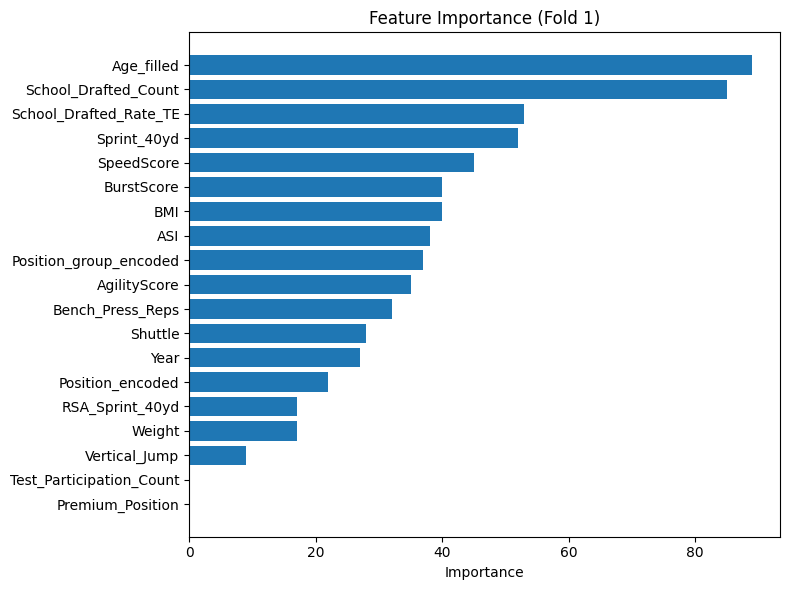

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.857403	valid_0's binary_logloss: 0.411912
✅ Fold 2 - Train AUC: 0.9343, Validation AUC: 0.8574
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data po

In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

# 追加削除カラム
drop_cols_additional = ["RSA_Vertical_Jump", "Broad_Jump", "Height", "Agility_3cone"]

# すでに削除済のカラム＋追加カラム
drop_cols_total = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
] + drop_cols_additional

# カラム削除
X_reduced2 = X.drop(columns=[col for col in drop_cols_total if col in X.columns])

# モデル定義（パラメータそのまま）
model = LGBMClassifier(
    max_depth=8,
    num_leaves=10,
    min_child_samples=10,
    reg_alpha=0.0415,
    reg_lambda=0.2428,
    learning_rate=0.0726,
    n_estimators=1000,
    subsample=0.6898,
    colsample_bytree=0.7463,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # Fold 1 のみ Feature Importance 可視化
    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns

        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(importances)), importances[sorted_idx])
        plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.86515	valid_0's binary_logloss: 0.401981
✅ Fold 1 - Train AUC: 0.9206, Validation AUC: 0.8651


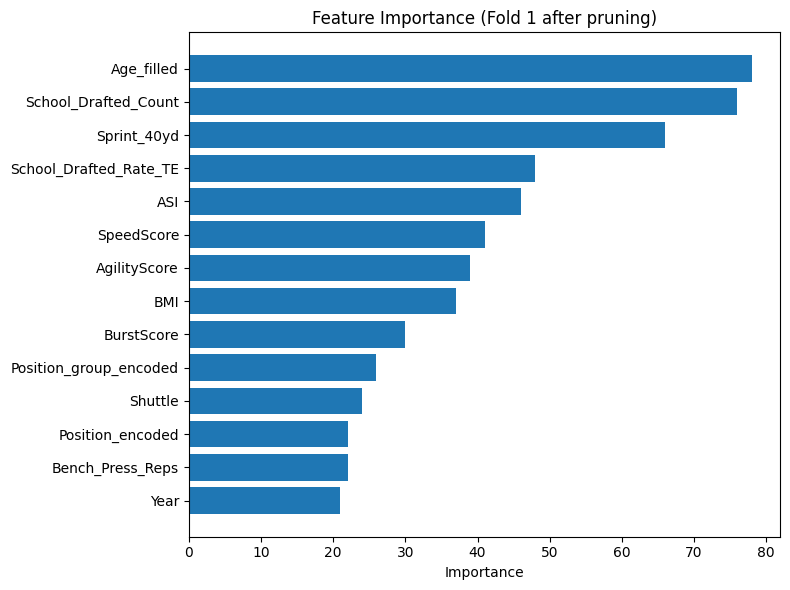

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1644
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.857662	valid_0's binary_logloss: 0.415921
✅ Fold 2 - Train AUC: 0.9206, Validation AUC: 0.8577
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data po

In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

# 🚩 削除対象カラム
drop_cols_recheck = [
    "Premium_Position",
    "Test_Participation_Count",
    "RSA_Sprint_40yd",
    "Weight",
    "Vertical_Jump"
]

# カラム削除
X_reduced3 = X_reduced2.drop(columns=[col for col in drop_cols_recheck if col in X_reduced2.columns])

# モデル定義（パラメータそのまま）
model = LGBMClassifier(
    max_depth=8,
    num_leaves=10,
    min_child_samples=10,
    reg_alpha=0.0415,
    reg_lambda=0.2428,
    learning_rate=0.0726,
    n_estimators=1000,
    subsample=0.6898,
    colsample_bytree=0.7463,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced3)):
    X_train, X_valid = X_reduced3.iloc[train_idx], X_reduced3.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # Fold 1のみFeature Importance可視化
    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns

        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(importances)), importances[sorted_idx])
        plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
        plt.title("Feature Importance (Fold 1 after pruning)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1803, number of negative: 978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 2781, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648328 -> initscore=0.611698
[LightGBM] [Info] Start training from score 0.611698


c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


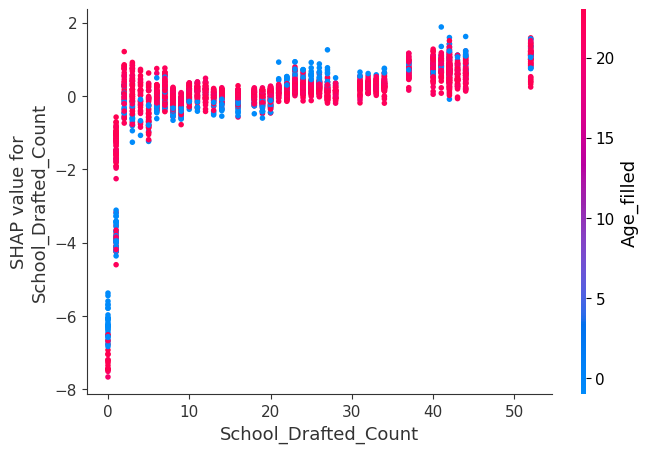

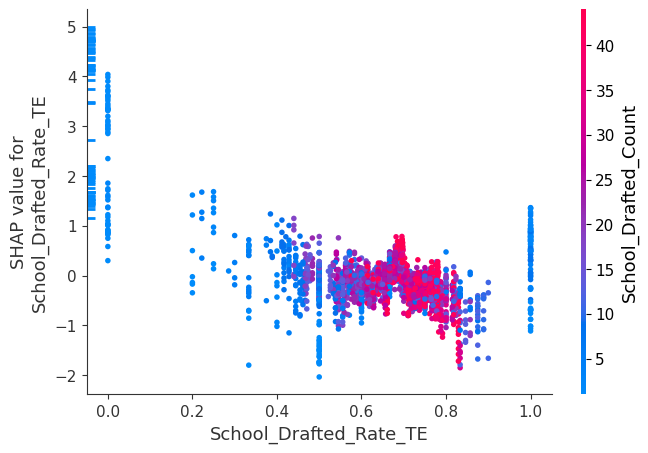

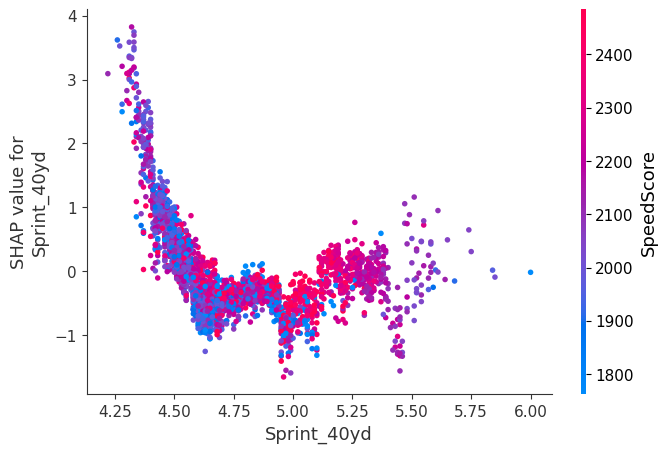

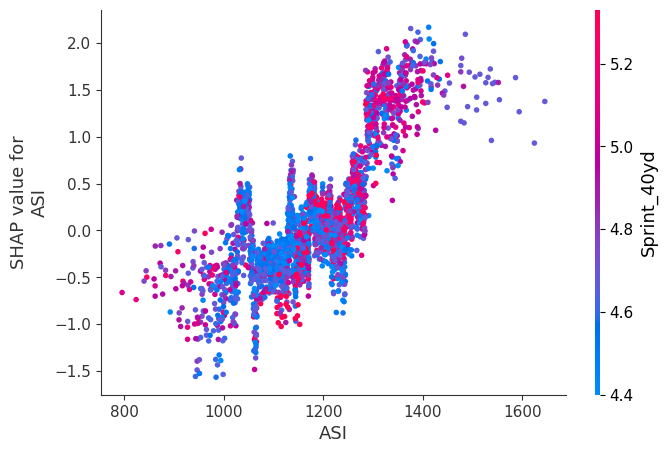

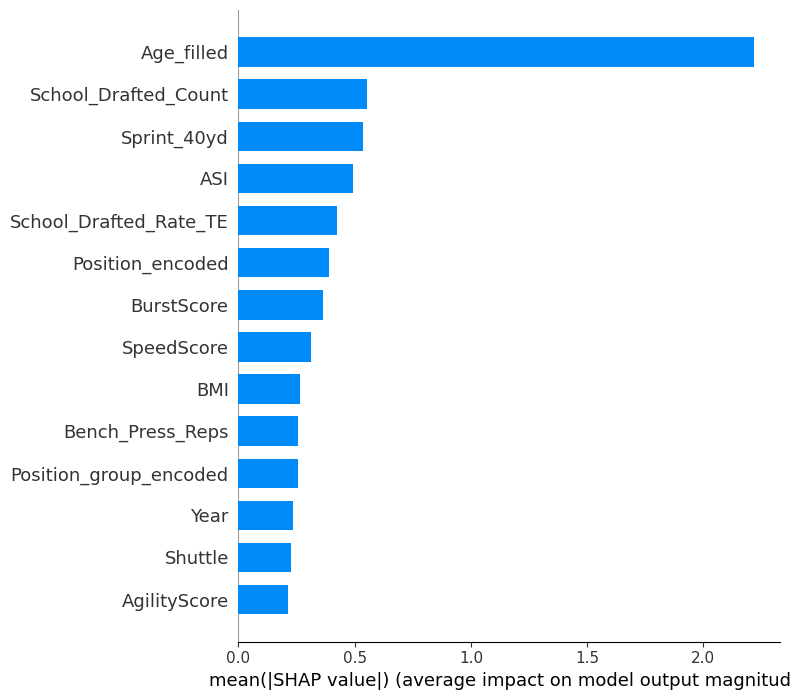

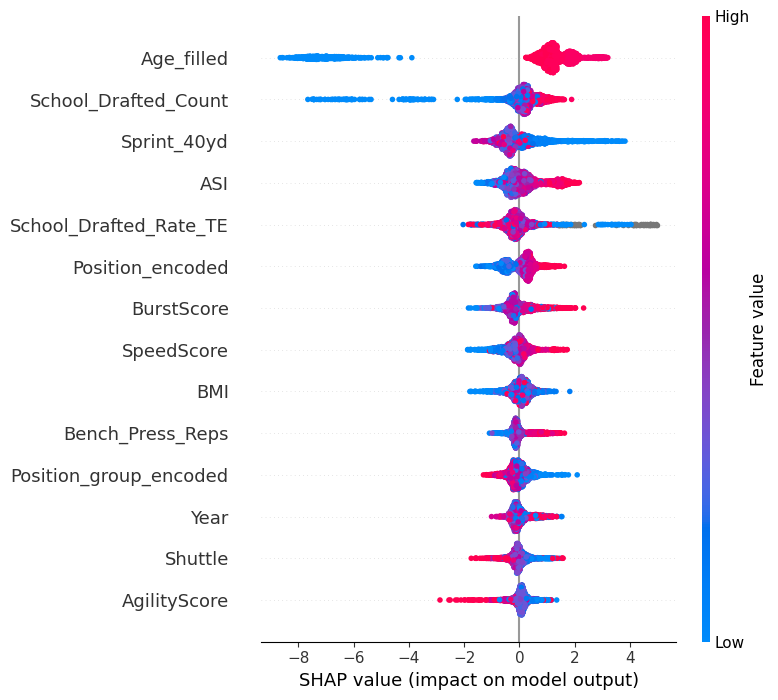

✅ SHAP解析完了：上記のグラフで寄与方向・閾値特性を確認してください。


In [85]:
import shap

# 🚩 LightGBM + SHAP解析

# モデル再学習（Fold 0のモデルをそのまま再利用）
model.fit(X_reduced3, y)

# SHAP値計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_reduced3)

# 🚩 重要特徴量4つの SHAP Dependence Plot

target_features = ["School_Drafted_Count", "School_Drafted_Rate_TE", "Sprint_40yd", "ASI"]

for feature in target_features:
    if feature in X_reduced3.columns:
        shap.dependence_plot(feature, shap_values, X_reduced3, show=True)
    else:
        print(f"⚠️ {feature} は X_reduced3 に存在しません")

# 🚩 全体 SHAP Summary Plot（バー形式）
shap.summary_plot(shap_values, X_reduced3, plot_type="bar", max_display=20)

# 🚩 全体 SHAP Summary Plot（ドット形式）
shap.summary_plot(shap_values, X_reduced3, max_display=20)

print("✅ SHAP解析完了：上記のグラフで寄与方向・閾値特性を確認してください。")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.859633	valid_0's binary_logloss: 0.420451
✅ Fold 1 - Train AUC: 0.8935, Validation AUC: 0.8596


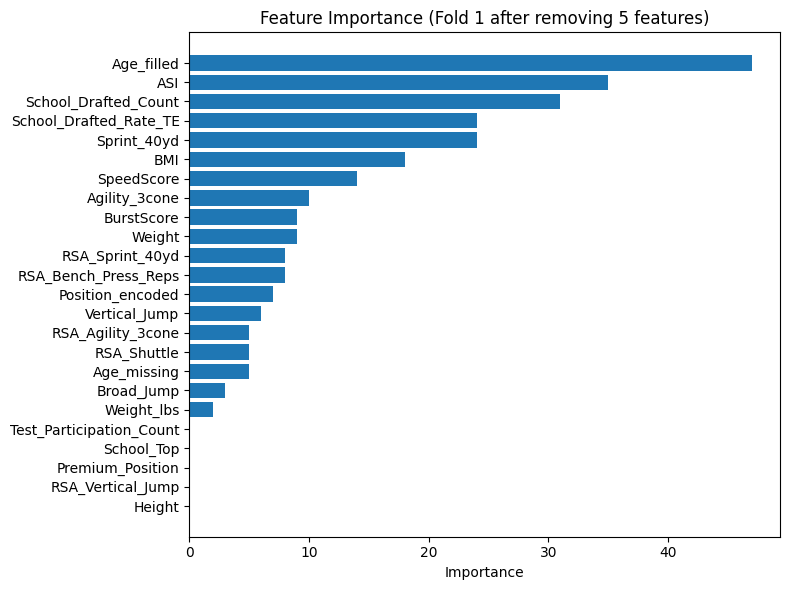

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.870605	valid_0's binary_logloss: 0.403876
✅ Fold 2 - Train AUC: 0.9250, Validation AUC: 0.8706
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data po

In [86]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

# 🚩 削除対象カラム
drop_cols_final = [
    "Shuttle",
    "AgilityScore",
    "Year",
    "Position_group_encoded",
    "Bench_Press_Reps"
]

# 最新Xから再削除適用
X_reduced_final = X.drop(columns=[col for col in drop_cols_final if col in X.columns])

# モデル定義（パラメータはそのまま）
model = LGBMClassifier(
    max_depth=8,
    num_leaves=10,
    min_child_samples=10,
    reg_alpha=0.0415,
    reg_lambda=0.2428,
    learning_rate=0.0726,
    n_estimators=1000,
    subsample=0.6898,
    colsample_bytree=0.7463,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced_final)):
    X_train, X_valid = X_reduced_final.iloc[train_idx], X_reduced_final.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # Fold 1のみFeature Importance可視化
    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns

        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(importances)), importances[sorted_idx])
        plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
        plt.title("Feature Importance (Fold 1 after removing 5 features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


## 🚩 削除候補（重要度ほぼゼロ）
Test_Participation_Count

School_Top

Premium_Position

RSA_Vertical_Jump

Height



[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.86202	valid_0's binary_logloss: 0.40045
✅ Fold 1 - Train AUC: 0.9448, Validation AUC: 0.8620


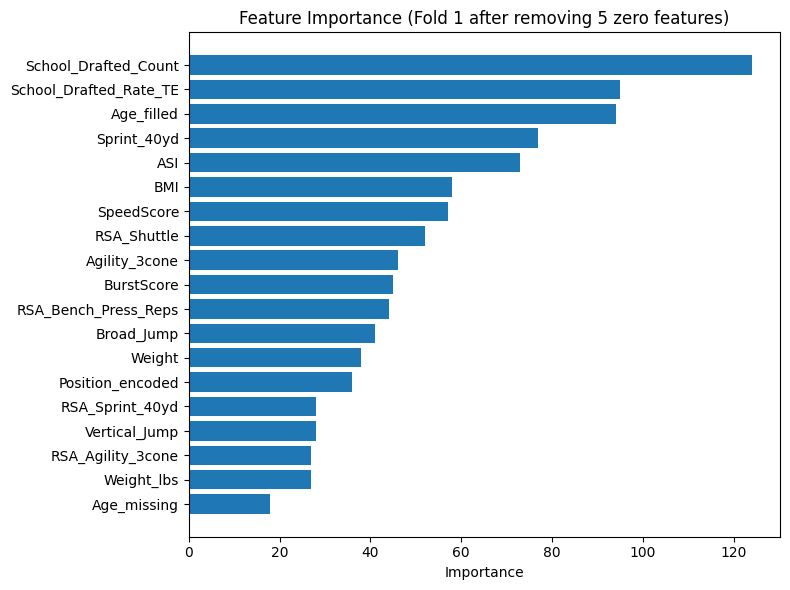

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.863128	valid_0's binary_logloss: 0.408795
✅ Fold 2 - Train AUC: 0.9213, Validation AUC: 0.8631
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data po

In [87]:
# 🚩 追加削除対象カラム
drop_cols_next = [
    "Test_Participation_Count",
    "School_Top",
    "Premium_Position",
    "RSA_Vertical_Jump",
    "Height"
]

# 最新削除適用
X_reduced_next = X_reduced_final.drop(columns=[col for col in drop_cols_next if col in X_reduced_final.columns])

# 学習ループは同じパラメータで実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced_next)):
    X_train, X_valid = X_reduced_next.iloc[train_idx], X_reduced_next.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(importances)), importances[sorted_idx])
        plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
        plt.title("Feature Importance (Fold 1 after removing 5 zero features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


In [88]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X_reduced2.columns で確定させる
feature_cols = X_reduced2.columns.tolist()

# test に存在しない列があれば埋める（安全）
missing_cols = set(feature_cols) - set(test.columns)
for col in missing_cols:
    test[col] = 0

# 列順を揃える
X_test = test[feature_cols]

# 予測
y_pred = model.predict_proba(X_test)[:, 1]


# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred
})

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "13_0630_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_13_0630.csv
